In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Resampling the data on a daily basis

In [12]:
df = pd.read_csv('bitcoin_price.csv')
df.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)','High','Low'],axis=1, inplace=True)
df.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [13]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

In [14]:
df.index = df.Timestamp
df_day = df.resample('D').mean()
df_day.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


## Finding the NaNs in the dataset

In [15]:

# Find missing values
for i, r in df_day.iterrows():
    if r.isnull().sum() > 0:
        print(i)
        print(r)
        print()

# Print the records of the date between the missing records
print()
print('Data at 2015-01-05')
print(df_day.loc['2015-01-05'])

print()
print('Data at 2015-01-09')
print(df_day.loc['2015-01-09'])

2015-01-06 00:00:00
Weighted_Price   NaN
Name: 2015-01-06 00:00:00, dtype: float64

2015-01-07 00:00:00
Weighted_Price   NaN
Name: 2015-01-07 00:00:00, dtype: float64

2015-01-08 00:00:00
Weighted_Price   NaN
Name: 2015-01-08 00:00:00, dtype: float64


Data at 2015-01-05
Weighted_Price    272.13919
Name: 2015-01-05 00:00:00, dtype: float64

Data at 2015-01-09
Weighted_Price    291.885251
Name: 2015-01-09 00:00:00, dtype: float64


## Replace the NaNs with the mean value of the day before and after

In [16]:
missing_replacement = df['2015-01-05': '2015-01-09'].mean(numeric_only=True)
df_day.loc['2015-01-06'] = missing_replacement
df_day.loc['2015-01-07'] = missing_replacement
df_day.loc['2015-01-08'] = missing_replacement

# Any missing value?
df_day.isnull().sum()

Weighted_Price    0
dtype: int64

In [17]:
df_day.shape

(3289, 1)

## Scale the dataset from 0 to 1

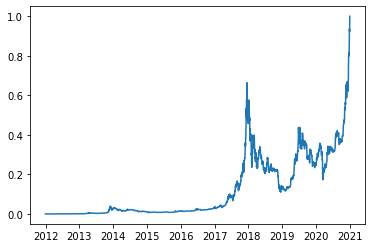

In [18]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(df_day['Weighted_Price']).reshape(-1,1))
df_day['Weighted_Price'] = price

plt.plot(df_day)
plt.show()

## Define the window size and split the training test data

In [19]:
window_size = 100
df_train = df_day.loc['2011-12-31':'2019-12-31']  # training the model with data set before 2019-12-31
df_test = df_day.loc['2020-1-1':]
df_train['Predicted_Price'] = df_train[['Weighted_Price']].shift(-window_size)

X = df_train[['Weighted_Price']].values[:-window_size].reshape(-1,1)
y = df_train.Predicted_Price.values[:-window_size]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)
y_test.shape, window_size,df_day.head()

<ipython-input-19-0a74eea23628>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Predicted_Price'] = df_train[['Weighted_Price']].shift(-window_size)


((565,),
 100,
             Weighted_Price
 Timestamp                 
 2011-12-31        0.000005
 2012-01-01        0.000016
 2012-01-02        0.000023
 2012-01-03        0.000032
 2012-01-04        0.000030)

## Define and fit the LR and SVR models

In [20]:
svr = SVR(kernel='rbf', C=10)
svr.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Plot the SVR prediction results

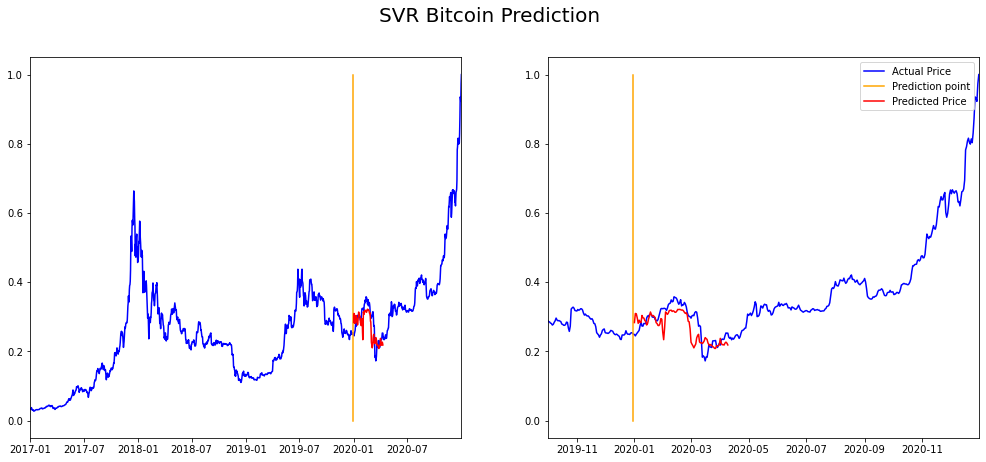

In [21]:
plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1) #subplot
plt.plot(df_day.index.values, df_day.Weighted_Price.values, 'blue', 
         label='Actual Price')
plt.plot([date(2019, 12, 31), date(2019, 12, 31)], [0, 1], 'orange', 
         label='Prediction point')

y_predict_svr_test = svr.predict( df_train[-window_size:].Weighted_Price.values.reshape(-1, 1) )  # predict 100 (sliding window size) prices after 2020-1-1

plt.plot(df_test.index.values[:window_size], y_predict_svr_test, 'red',
        label='Predicted Price')
plt.xlim(date(2016, 12, 31), date(2020, 12, 31))


plt.subplot(1, 2, 2)
plt.plot(df_day.index.values, df_day.Weighted_Price.values, 'blue', 
         label='Actual Price')
plt.plot([date(2019, 12, 31), date(2019, 12, 31)], [0, 1], 'orange', 
         label='Prediction point')

y_predict_svr_test = svr.predict(
    df_train[-window_size:].Weighted_Price.values.reshape(-1, 1),
)
y_predict_svr_test2 = svr.predict(
    y_predict_svr_test.reshape(-1,1)
)
plt.plot(df_test.index.values[:window_size], y_predict_svr_test, 'red',
        label='Predicted Price')
plt.xlim(date(2019, 10, 1), date(2020, 12, 31))
plt.legend()



plt.suptitle('SVR Bitcoin Prediction',fontsize=20)
plt.savefig('SVRpred.png')
plt.show()

## Plot the LR prediction results

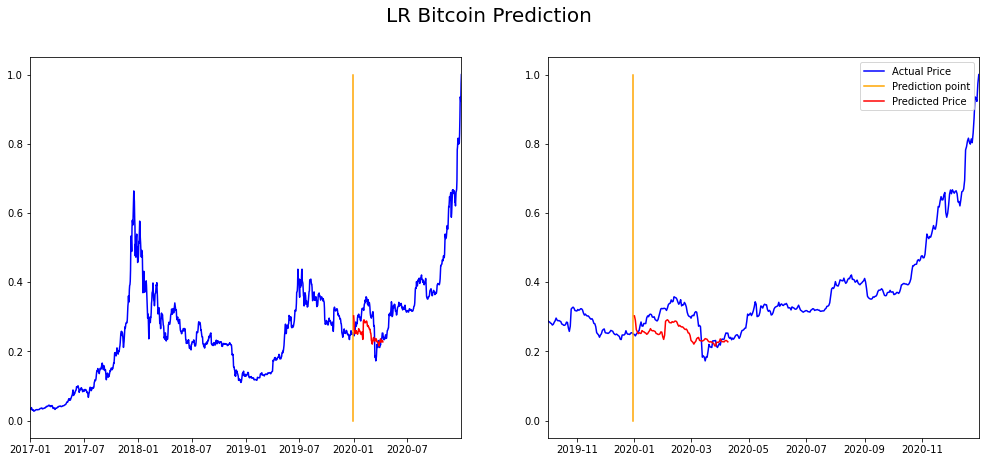

In [22]:
plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)
plt.plot(df_day.index.values, df_day.Weighted_Price.values, 'blue', 
         label='Actual Price')
plt.plot([date(2019, 12, 31), date(2019, 12, 31)], [0, 1], 'orange', 
         label='Prediction point')

y_predict_lr_test = lr.predict(
    df_train[-window_size:].Weighted_Price.values.reshape(-1, 1),
)

plt.plot(df_test.index.values[:window_size], y_predict_lr_test, 'red',
        label='Predicted Price')
plt.xlim(date(2016, 12, 31), date(2020, 12, 31))


plt.subplot(1, 2, 2)
plt.plot(df_day.index.values, df_day.Weighted_Price.values, 'blue', 
         label='Actual Price')
plt.plot([date(2019, 12, 31), date(2019, 12, 31)], [0, 1], 'orange', 
         label='Prediction point')

y_predict_lr_test = lr.predict(
    df_train[-window_size:].Weighted_Price.values.reshape(-1, 1),
)

plt.plot(df_test.index.values[:window_size], y_predict_lr_test, 'red',
        label='Predicted Price')
plt.xlim(date(2019, 10, 1), date(2020, 12, 31))
plt.legend()



plt.suptitle('LR Bitcoin Prediction',fontsize=20)
plt.savefig('LRpred.png')
plt.show()

## Performance Evaluation (four metrics: MAPE MAE MSE R2 score)

In [23]:
y_test = df_test.Weighted_Price.values[0:window_size]
mean_squared_error(y_test, y_predict_svr_test, squared=False), mean_squared_error(y_test, y_predict_lr_test, squared=False)

(0.03650236889629175, 0.0489656476149748)

In [26]:
mean_absolute_percentage_error(y_test, y_predict_svr_test), mean_absolute_percentage_error(y_test, y_predict_lr_test)

(0.1019270431480353, 0.002397634646353887)

In [27]:
mean_absolute_error(y_test, y_predict_svr_test), mean_absolute_error(y_test, y_predict_lr_test)

(0.02799858096993075, 0.042582136925290434)

In [28]:
r2_score(y_test, y_predict_svr_test), r2_score(y_test, y_predict_lr_test)

(0.4404835840430945, -0.006824416498641517)